In [1]:
# import config + dataset stuff
from training.dataset.vos_dataset import VOSDataset
import training.dataset.vos_sampler as vos_sampler
import random
from omegaconf import OmegaConf
from hydra import compose, initialize_config_module
from hydra.utils import instantiate
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import torch

In [2]:
initialize_config_module("sam2", version_base="1.2")

hydra.initialize_config_module()

In [9]:
cfg_path = "../sam2/configs/sam2.1_training/sam2.1_hiera_t_finetune_sparsev2.yaml"
cfg = compose(config_name=cfg_path)

In [10]:
vos_dataset = instantiate(cfg.trainer.data.train.datasets[0].dataset.datasets[0])

Raw dataset length = 35544


## Custom Defined Sampler

if you want to play around with the sampler, customize one here and run both blocks. otherwise... don't.

In [12]:
class SparseSamplerV2(vos_sampler.VOSSampler):
    def __init__(
        self,
        num_frames,
        max_num_objects,
        random_permute=False,
    ):
        self.num_frames = num_frames
        self.max_num_objects = max_num_objects
        self.random_permute = random_permute

    def sample(self, video, segment_loader, epoch=None):

        for retry in range(vos_sampler.MAX_RETRIES):
            if len(video.frames) < self.num_frames:
                raise Exception(
                    f"Cannot sample {self.num_frames} frames from video {video.video_name} as it only has {len(video.frames)} annotated frames."
                )
            
            step_sz = (len(video.frames)-1) / (self.num_frames-1) if self.num_frames != 1 and len(video.frames) != 1 else 0
            frames = [video.frames[round(step * step_sz)] for step in range(self.num_frames)]
            if self.random_permute:
                # want to permute here:
                random.shuffle(frames)

            # Get first frame object ids
            visible_object_ids = []
            loaded_segms = segment_loader.load(frames[0].frame_idx)
            if isinstance(loaded_segms, vos_sampler.LazySegments):
                # LazySegments for SA1BRawDataset
                visible_object_ids = list(loaded_segms.keys())
            else:
                for object_id, segment in segment_loader.load(
                    frames[0].frame_idx
                ).items():
                    if segment.sum():
                        visible_object_ids.append(object_id)

            # First frame needs to have at least a target to track
            if len(visible_object_ids) > 0:
                break
            if retry >= vos_sampler.MAX_RETRIES - 1:
                raise Exception("No visible objects")

        object_ids = random.sample(
            visible_object_ids,
            min(len(visible_object_ids), self.max_num_objects),
        )
        return vos_sampler.SampledFramesAndObjects(frames=frames, object_ids=object_ids)



In [16]:
vos_dataset.sampler = SparseSamplerV2(4, 3, random_permute=True)

In [75]:
i = 0

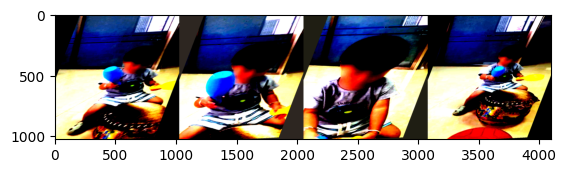

In [85]:
sample = vos_dataset._get_datapoint(i)
plt.imshow(torch.cat([sample.frames[i].data for i in range(len(sample.frames))], dim=2).permute(1,2,0))
i += 1

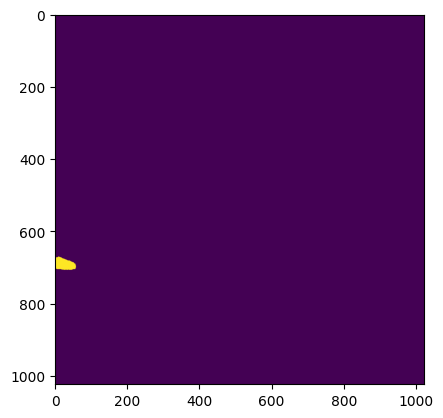

In [73]:
plt.imshow(sample.frames[3].objects[0].segment.unsqueeze(2))